## Descripción del Dataset MHEALTH

El dataset MHEALTH (Mobile Health) contiene registros sincronizados de movimiento corporal y señales vitales de 10 voluntarios mientras ejecutan 12 actividades físicas definidas. Su propósito es servir como benchmark para tareas de reconocimiento de actividad humana (HAR) y análisis multimodal de series temporales.

### Resumen Estructural
- Sujetos: 10  
- Actividades: 12  
- Dispositivos: 3 (pecho, muñeca derecha, tobillo izquierdo)  
- Frecuencia de muestreo: 50 Hz en todos los canales  
- Modalidades: Acelerómetro (3 ejes), Giroscopio (3 ejes), Magnetómetro (3 ejes) en cada ubicación + ECG de 2 derivaciones en el sensor del pecho  
- Total de canales crudos principales presentes en este notebook: 23 señales continuas + etiqueta de actividad + ID de sujeto + nombre de actividad (derivado)  

### Actividades (Protocolo)
Cada sujeto ejecuta el siguiente conjunto (códigos 1–12 en la fuente, aquí mapeados si aplica):
1. Standing still (1 min)  
2. Sitting and relaxing (1 min)  
3. Lying down (1 min)  
4. Walking (1 min)  
5. Climbing stairs (1 min)  
6. Waist bends forward (20 repeticiones)  
7. Frontal elevation of arms (20 repeticiones)  
8. Knees bending (crouching) (20 repeticiones)  
9. Cycling (1 min)  
10. Jogging (1 min)  
11. Running (1 min)  
12. Jump front & back (20 repeticiones)  

En este notebook el diccionario ACTIVITY_MAP incluye además la etiqueta 0 (null) para segmentos sin actividad válida.

### Sensores y Señales
Ubicaciones:
1. Pecho: acelerómetro, giroscopio, magnetómetro, ECG (2 derivaciones)  
2. Muñeca derecha: acelerómetro, giroscopio  
3. Tobillo izquierdo: acelerómetro, giroscopio  

El magnetómetro registrado corresponde a la unidad del pecho. Las columnas se encuentran ya estandarizadas según el esquema proporcionado en COLUMN_NAMES.


In [1]:
import os
import zipfile
import re
import urllib.request
from pathlib import Path

import pandas as pd

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
DATA_DIR = Path("data/mhealth")            # Carpeta destino local
ZIP_PATH = DATA_DIR / "MHEALTHDATASET.zip"  # Ruta del zip descargado
RAW_DIR = DATA_DIR / "MHEALTHDATASET"       # Carpeta que contiene los .log

# Columnas según la documentación (23 señales + etiqueta de actividad)
COLUMN_NAMES = [
    'chest_acc_x','chest_acc_y','chest_acc_z',
    'chest_gyro_x','chest_gyro_y','chest_gyro_z',
    'chest_mag_x','chest_mag_y','chest_mag_z',
    'chest_ecg_1','chest_ecg_2',
    'right_wrist_acc_x','right_wrist_acc_y','right_wrist_acc_z',
    'right_wrist_gyro_x','right_wrist_gyro_y','right_wrist_gyro_z',
    'left_ankle_acc_x','left_ankle_acc_y','left_ankle_acc_z',
    'left_ankle_gyro_x','left_ankle_gyro_y','left_ankle_gyro_z',
    'activity'
]

# Mapeo de actividades (incluye 0 = segmento no válido / transición)
ACTIVITY_MAP = {
    0: 'No definida / Transición',
    1: 'Quieto de pie',
    2: 'Sentado relajado',
    3: 'Acostado',
    4: 'Caminando',
    5: 'Subiendo escaleras',
    6: 'Flexión de cintura',
    7: 'Elevación frontal de brazos',
    8: 'Flexión de rodillas (crouching)',
    9: 'Ciclismo',
    10: 'Trote',
    11: 'Corriendo',
    12: 'Saltos adelante/atrás'
}

os.makedirs(DATA_DIR, exist_ok=True)

# --------------------------------------------------------------
# Descarga con barra de progreso simple
# --------------------------------------------------------------

def _progress_hook(block_count: int, block_size: int, total_size: int):
    if total_size > 0:
        downloaded = block_count * block_size
        pct = min(downloaded / total_size * 100, 100)
        mb_down = downloaded / 1_048_576
        mb_total = total_size / 1_048_576
        print(f"\rDescargando: {pct:5.1f}% ({mb_down:.2f}/{mb_total:.2f} MB)", end='')


def download_dataset():
    if RAW_DIR.exists() and any(RAW_DIR.glob("mHealth_subject*.log")):
        print("Dataset ya presente. Se omite descarga.")
        return
    if not ZIP_PATH.exists():
        print("Descargando dataset MHEALTH ...")
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH, _progress_hook)
        print("\nDescarga completa.")
    else:
        print("Archivo ZIP ya existe. Saltando descarga.")

    if not RAW_DIR.exists():
        print("Descomprimiendo...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as z:
            z.extractall(DATA_DIR)
        print("Listo.")
    else:
        print("Carpeta descomprimida ya presente.")

# --------------------------------------------------------------
# Carga de todos los sujetos
# --------------------------------------------------------------

def load_all_subjects(sample_fraction: float | None = None) -> pd.DataFrame:
    """Lee todos los archivos mHealth_subjectX.log y construye un DataFrame.
    Parámetros:
        sample_fraction: si se indica (0<fr<=1), toma una fracción aleatoria para pruebas rápidas.
    """
    logs = sorted(RAW_DIR.glob("mHealth_subject*.log"))
    if not logs:
        raise FileNotFoundError("No se encontraron archivos de sujetos en la carpeta RAW. Verifique la descarga.")

    dfs = []
    pattern = re.compile(r"mHealth_subject(\d+)\.log")
    for path in logs:
        match = pattern.search(path.name)
        subject_id = int(match.group(1)) if match else None
        df = pd.read_csv(
            path,
            sep='\\s+',
            header=None,
            names=COLUMN_NAMES,
            dtype='float32',
            engine='python'
        )
        # Convertir actividad a int
        df['activity'] = df['activity'].astype('int16')
        df['subject'] = subject_id
        dfs.append(df)

    full = pd.concat(dfs, ignore_index=True)
    full['activity_name'] = full['activity'].map(ACTIVITY_MAP).astype('category')
    full['subject'] = full['subject'].astype('int8')

    if sample_fraction is not None:
        full = full.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        print(f"Muestreo aplicado: {sample_fraction*100:.1f}% de los registros")

    return full

# --------------------------------------------------------------
# Ejecución
# --------------------------------------------------------------
if __name__ == "__main__":
    download_dataset()
    mhealth_df = load_all_subjects(sample_fraction=None)

    print("Resumen inicial:")
    print("Filas:", len(mhealth_df), "| Columnas:", mhealth_df.shape[1])
    print("Columnas:", list(mhealth_df.columns))
    print("Actividades presentes (top):")
    print(mhealth_df['activity_name'].value_counts())
    print()
    print("Ejemplo de registros:")
    display(mhealth_df.sample(10))


Dataset ya presente. Se omite descarga.
Resumen inicial:
Filas: 1215745 | Columnas: 26
Columnas: ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'chest_ecg_1', 'chest_ecg_2', 'right_wrist_acc_x', 'right_wrist_acc_y', 'right_wrist_acc_z', 'right_wrist_gyro_x', 'right_wrist_gyro_y', 'right_wrist_gyro_z', 'left_ankle_acc_x', 'left_ankle_acc_y', 'left_ankle_acc_z', 'left_ankle_gyro_x', 'left_ankle_gyro_y', 'left_ankle_gyro_z', 'activity', 'subject', 'activity_name']
Actividades presentes (top):
activity_name
No definida / Transición           872550
Caminando                           30720
Ciclismo                            30720
Corriendo                           30720
Acostado                            30720
Trote                               30720
Quieto de pie                       30720
Subiendo escaleras                  30720
Sentado relajado                    30720
Elevación frontal de 

,chest_acc_x,chest_acc_y,chest_acc_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_mag_x,chest_mag_y,chest_mag_z,chest_ecg_1,...,right_wrist_gyro_z,left_ankle_acc_x,left_ankle_acc_y,left_ankle_acc_z,left_ankle_gyro_x,left_ankle_gyro_y,left_ankle_gyro_z,activity,subject,activity_name
401946,-8.32550,1.12430,-4.59360,0.351650,0.138150,3.068200,-9.3721,-2.55250,0.73098,-0.50281,...,1.69300,0.63725,-0.710470,-0.025862,0.185000,0.546210,0.359250,2,3,Sentado relajado
297453,-8.63140,-0.24750,0.96720,-0.079540,0.025118,-2.101700,-3.0987,1.02200,-0.72542,-0.16135,...,-0.87294,-0.80588,-0.002053,-0.650860,-4.468300,2.006500,14.692000,0,2,No definida / Transición
1061326,-8.26150,-2.58310,1.56750,1.306100,2.059700,3.074500,-9.2451,0.24557,0.67347,-0.62101,...,1.23150,0.28824,-0.952770,0.640090,0.273300,9.377000,-23.915001,0,8,No definida / Transición
762615,-0.43986,-4.77480,8.34920,0.297230,0.142330,4.868200,1.2631,8.48680,0.44156,1.00000,...,7.06550,-0.35098,0.597540,0.853450,0.179410,-0.012587,-1.079300,3,6,Acostado
438831,-9.57110,-0.74035,-0.18242,-1.013100,0.594450,0.674710,-9.6363,1.71240,-0.42672,-0.87805,...,1.89430,-0.51176,-0.878850,-0.370690,-4.002000,12.731000,-1.290400,8,3,Flexión de rodillas (crouching)
1035115,-9.96650,0.84854,1.13950,-0.732600,-0.987960,0.691450,-7.6429,-6.86480,-0.77737,-0.37523,...,5.24670,-0.66471,-0.882960,0.129310,-11.025000,10.613000,-20.542999,0,8,No definida / Transición
655005,-3.65740,4.58520,-6.61890,0.611200,4.445800,0.549250,-9.6497,0.37717,-0.66419,-0.73921,...,-1.56680,-0.84510,-0.622180,0.191810,9.714300,1.953200,41.691002,6,5,Flexión de cintura
357859,-8.82860,-1.49810,2.60200,-0.213500,-0.351650,1.507600,-9.6211,-1.71600,-0.49351,-0.72795,...,2.24050,-0.60000,-0.763860,-0.517240,-38.768002,-52.750000,58.236000,0,2,No definida / Transición
1045571,-7.15230,2.56250,-4.81150,0.694920,0.284670,0.050771,-7.4504,-5.43450,0.40260,-0.14259,...,6.47830,0.40980,-1.112900,0.209050,7.488900,-5.147300,0.923270,9,8,Ciclismo
1068388,-21.84000,0.10450,5.08310,-0.004186,-0.694920,0.883580,-8.9063,-13.40500,0.67161,-0.64728,...,-3.05250,-0.46275,0.383980,1.015100,-130.330002,72.802002,53.705002,0,8,No definida / Transición


## Tarea 1: Análisis Descriptivo (Gráficos Univariados y Multivariados)

En esta sección se generan visualizaciones exploratorias básicas sobre un subconjunto representativo de las señales:
1. Histogramas + curvas de densidad (KDE) para variables inerciales crudas (aceleraciones y giroscopios) de cada ubicación.
2. Boxplots de magnitudes vectoriales (acelerómetro) por actividad para comparar distribuciones y detectar posibles outliers.
3. Diagramas de dispersión entre ejes de acelerómetro y giroscopio (ej.: chest_acc_x vs chest_gyro_x) y entre magnitudes de distintas ubicaciones para observar relaciones lineales/no lineales y posibles agrupamientos por actividad.


### Preparación de Datos

En las siguientes celdas:
- Creamos magnitudes vectoriales (normas) para cada ubicación (pecho, muñeca derecha, tobillo izquierdo).
- Definimos una paleta de colores consistente por actividad para mantener coherencia visual.
- Vamos a quitar las filas con actividad 0 (transición) para mejorar la claridad en las visualizaciones.
- Aplicamos z-score normalization a las variables numéricas para facilitar la comparación entre diferentes escalas.

Esto establece la base común para todos los gráficos univariados y multivariados subsecuentes.

In [2]:
# Preparación de datos para visualizaciones de la Tarea 1 (con df y df_z)
# ----------------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Crear magnitudes de acelerómetro (sobre mhealth_df original)
mhealth_df['chest_acc_mag'] = np.sqrt(
    mhealth_df['chest_acc_x']**2 + mhealth_df['chest_acc_y']**2 + mhealth_df['chest_acc_z']**2
)
mhealth_df['right_wrist_acc_mag'] = np.sqrt(
    mhealth_df['right_wrist_acc_x']**2 + mhealth_df['right_wrist_acc_y']**2 + mhealth_df['right_wrist_acc_z']**2
)
mhealth_df['left_ankle_acc_mag'] = np.sqrt(
    mhealth_df['left_ankle_acc_x']**2 + mhealth_df['left_ankle_acc_y']**2 + mhealth_df['left_ankle_acc_z']**2
)

# 2) Filtrar filas con actividad != 0 (transición fuera)
df = mhealth_df[mhealth_df['activity'] != 0].reset_index(drop=True)

# 3) Construir df_z: z-score POR SUJETO (misma estructura/columnas que df)
df_z = df.copy()

# Columnas numéricas a estandarizar (excluye etiquetas/IDs)
label_cols = {'activity', 'subject'}  # dejarlas intactas
num_cols = df_z.select_dtypes(include=[np.number]).columns.tolist()
feat_cols = [c for c in num_cols if c not in label_cols]

# (Opcional) bajar a float32 para ahorrar memoria con 1.2M filas
df_z[feat_cols] = df_z[feat_cols].astype('float32')

# Medias y std por sujeto (vectorizado)
grp = df_z.groupby('subject', group_keys=False)
mu = grp[feat_cols].transform('mean')
sd = grp[feat_cols].transform(lambda s: s.std(ddof=0))

# Evitar divisiones por cero/NaN
sd = sd.replace(0, np.nan)
df_z[feat_cols] = ((df_z[feat_cols] - mu) / sd).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# 4) Paleta de colores por actividad (por si la usas más abajo)
base_palette = sns.color_palette('tab20', n_colors=13)
activities_sorted = sorted(df['activity'].unique())
activity_color_map = {act: (0.7, 0.7, 0.7) if act == 0 else base_palette[act % len(base_palette)]
                      for act in activities_sorted}

# 5) Submuestreo consistente para plots (mismas filas en df y df_z)
plot_df = df.copy()
plot_df_z = df_z.copy()

print("Filas totales (sin actividad 0):", len(df), "| Usadas en plots:", len(plot_df))
print("Columnas disponibles:", list(df.columns))


Filas totales (sin actividad 0): 343195 | Usadas en plots: 343195
Columnas disponibles: ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'chest_ecg_1', 'chest_ecg_2', 'right_wrist_acc_x', 'right_wrist_acc_y', 'right_wrist_acc_z', 'right_wrist_gyro_x', 'right_wrist_gyro_y', 'right_wrist_gyro_z', 'left_ankle_acc_x', 'left_ankle_acc_y', 'left_ankle_acc_z', 'left_ankle_gyro_x', 'left_ankle_gyro_y', 'left_ankle_gyro_z', 'activity', 'subject', 'activity_name', 'chest_acc_mag', 'right_wrist_acc_mag', 'left_ankle_acc_mag']


### Histogramas y Densidades (KDE) de Variables Inerciales

En este bloque se generan histogramas con curvas de densidad (KDE) para un subconjunto de ejes de acelerómetro y giroscopio de las tres ubicaciones. Esto permite evaluar:
- Dispersión y rango típico de valores.
- Posible asimetría o multimodalidad.
- Diferencias generales entre sensores y ubicaciones.

Se grafican algunas columnas para no sobrecargar la figura.

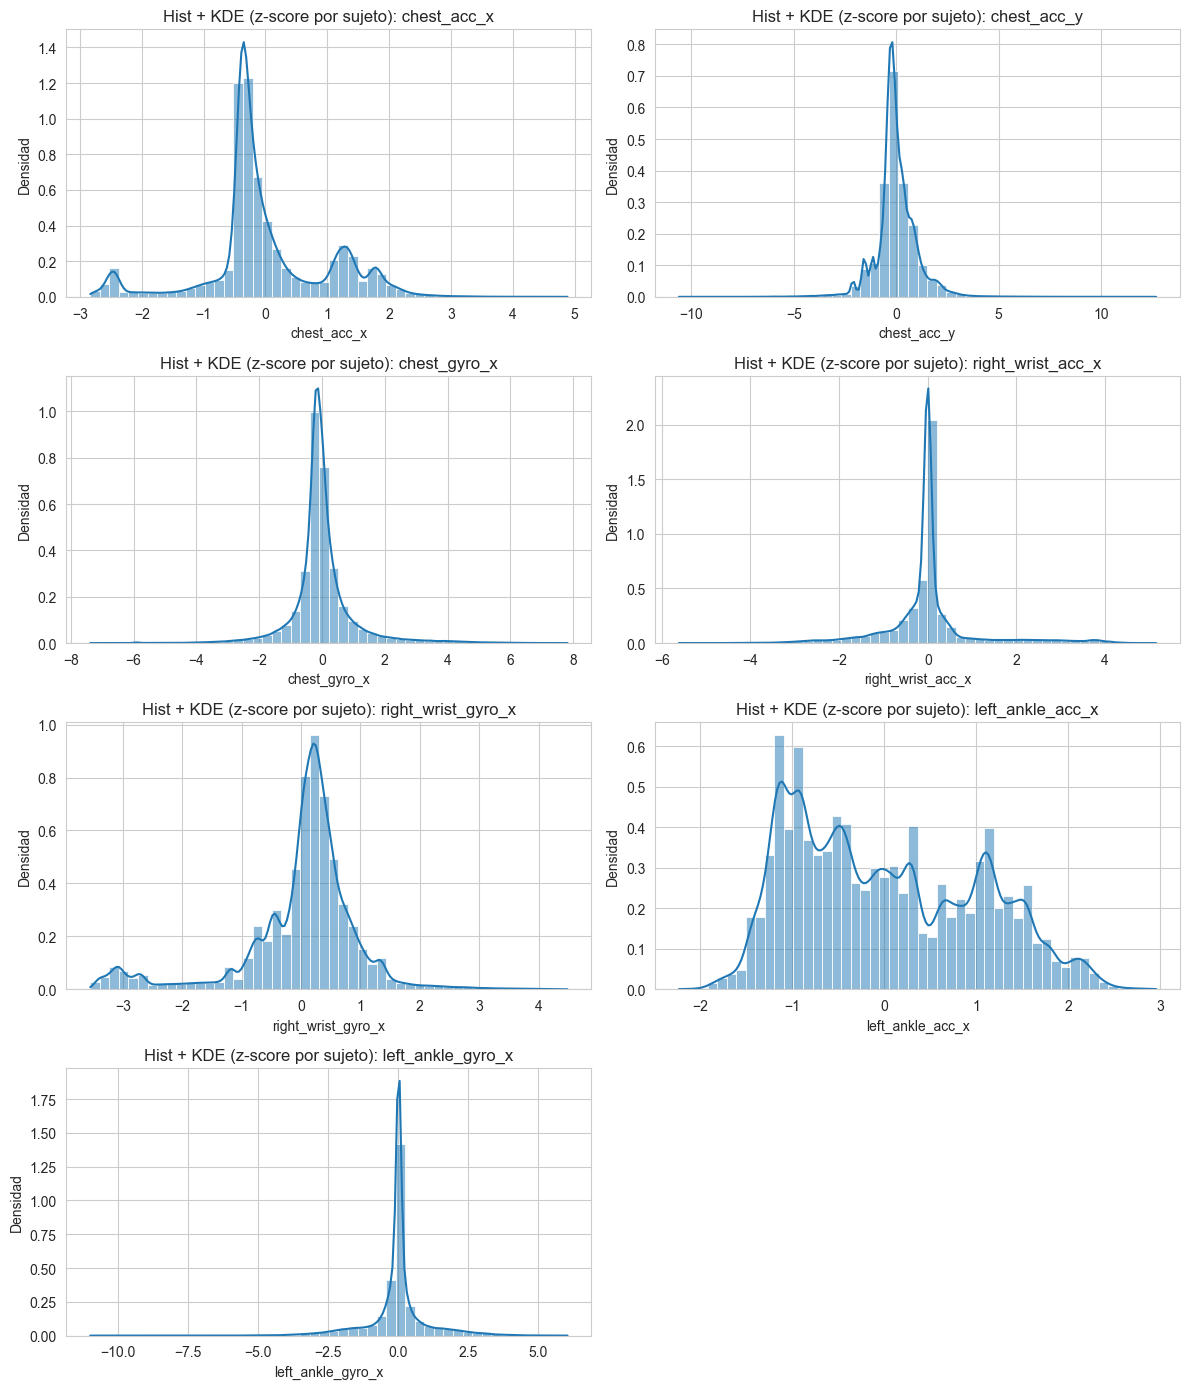

In [3]:
sns.set_style('whitegrid')
vars_hist = [
    'chest_acc_x','chest_acc_y','chest_gyro_x',
    'right_wrist_acc_x','right_wrist_gyro_x',
    'left_ankle_acc_x','left_ankle_gyro_x'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
axes = axes.flatten()
for i, col in enumerate(vars_hist):
    ax = axes[i]
    sns.histplot(plot_df_z[col].dropna(), kde=True, stat='density', bins=50, ax=ax)
    ax.set_title(f"Hist + KDE (z-score por sujeto): {col}")
    ax.set_xlabel(col)
    ax.set_ylabel('Densidad')
for j in range(len(vars_hist), len(axes)):
    axes[j].axis('off')
fig.tight_layout()
plt.show()


#### Interpretación de Histogramas y KDE
En general, tras estandarizar por sujeto (z-score), las distribuciones quedan centradas en 0 y hacen evidente un patrón común: el pecho muestra aceleraciones y rotaciones con picos muy marcados en torno a cero y varianza baja, propio de largos periodos de estabilidad con cambios de postura puntuales; la muñeca presenta colas más anchas y asimetrías, reflejando gestos amplios y rápidos del brazo; y el tobillo exhibe multimodalidad clara en aceleración (consistente con el ciclo de marcha: apoyo vs oscilación) junto a giroscopios con gran curtosis (periodos sin giro interrumpidos por ráfagas durante la zancada). Persisten colas largas en varios canales, lo que sugiere picos transitorios/artefactos pero también episodios de alta intensidad propios de ciertas actividades.

### Boxplots de Magnitudes de Acelerómetro por Actividad

Comparamos la distribución (mediana, IQR y posibles outliers) de la magnitud vectorial de aceleración en cada ubicación (pecho, muñeca derecha, tobillo izquierdo) separada por actividad. Esto ayuda a observar cómo la intensidad global del movimiento varía entre clases.

C:\Users\lucka\AppData\Local\Temp\ipykernel_1684\2320734727.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_box['activity_name']):


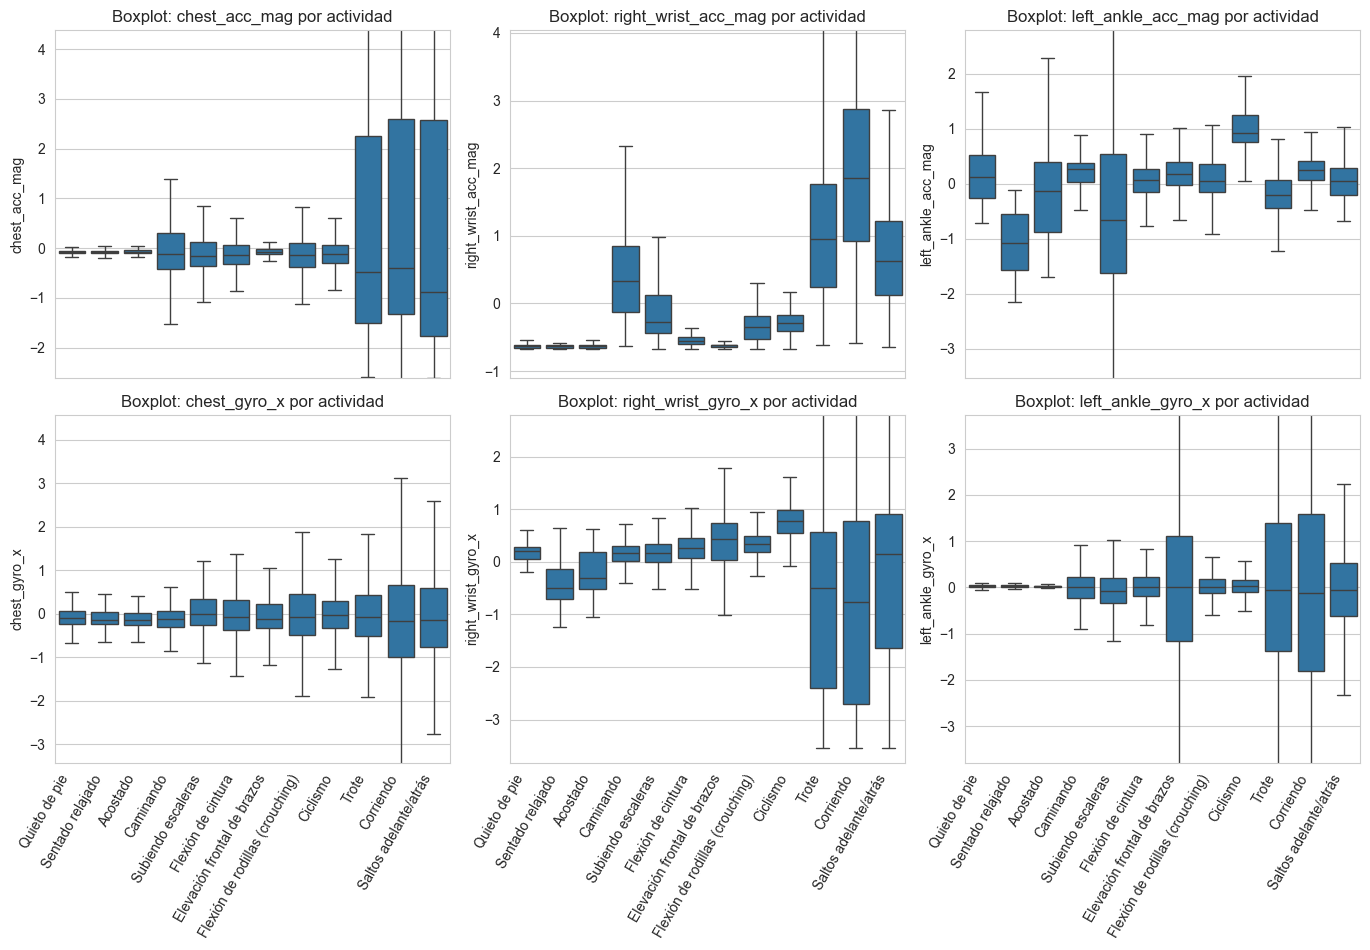

In [4]:
# ---------- Config ----------
df_box = plot_df_z.copy()

if pd.api.types.is_categorical_dtype(df_box['activity_name']):
    df_box['activity_name'] = df_box['activity_name'].cat.remove_unused_categories()


features = [
    'chest_acc_mag', 'right_wrist_acc_mag', 'left_ankle_acc_mag',
    'chest_gyro_x', 'right_wrist_gyro_x', 'left_ankle_gyro_x'
]

# orden de actividades en el eje X
# Orden según ACTIVITY_MAP (excluyendo 0 / transición)
act_order = [ACTIVITY_MAP[k] for k in ACTIVITY_MAP if k != 0 and ACTIVITY_MAP[k] in df_box['activity_name'].unique()]

# helper para límites robustos (evita que 1–2 valores extremos aplasten el boxplot)
def robust_ylim(s: pd.Series, q_low=0.01, q_high=0.99, pad=0.1):
    lo, hi = s.quantile([q_low, q_high]).values
    span = hi - lo
    return lo - pad*span, hi + pad*span

# ---------- Plot ----------
sns.set_style('whitegrid')
n = len(features)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.6*cols, 4.8*rows), sharex=True)
axes = np.array(axes).reshape(rows, cols)

for i, feat in enumerate(features):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    # boxplot sin 'fliers' para que no distorsione la escala
    sns.boxplot(
        data=df_box, x='activity_name', y=feat,
        order=act_order, showfliers=False, ax=ax
    )
    ax.set_title(f'Boxplot: {feat} por actividad')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
    # límites robustos por variable
    ylo, yhi = robust_ylim(df_box[feat].dropna())
    ax.set_ylim(ylo, yhi)
    for label in ax.get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')

# ocultar ejes vacíos si sobran
for j in range(i+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

fig.tight_layout()
plt.show()

#### Interpretación de Boxplots
Los boxplots confirman un patrón coherente por actividad: en posturas estáticas (quieto, sentado, acostado) las cajas son estrechas y centradas cerca de 0 en todos los sensores (baja variabilidad). A medida que aumenta la intensidad motora (caminar → subir escaleras → trote/correr → saltos), crecen simultáneamente la mediana y la dispersión, sobre todo en muñeca y tobillo: las magnitudes de aceleración y los giros (especialmente right_wrist_gyro_x y left_ankle_gyro_x) se abren claramente, dando buena separabilidad. Actividades de miembro superior (elevación de brazos) resaltan la muñeca con medianas más altas, mientras que el pecho mantiene variabilidad menor y más estable. Ciclismo aparece con perfiles intermedios: rotación apreciable pero aceleración menos impactante que correr/saltos. En conjunto, las diferencias de medianas/IQR por sensor-actividad sugieren que combinar señales de tobillo + muñeca aporta la mayor discriminación entre clases.

### Diagramas de Dispersión entre Ejes y Magnitudes

En este bloque se generan diagramas de dispersión (scatter plots) para explorar relaciones entre:
- Ejes individuales de acelerómetro y giroscopio en el pecho (ej.: chest_acc_x vs chest_gyro_x).
- Magnitudes de acelerómetro entre diferentes ubicaciones (ej.: chest_acc_mag vs right_wrist_acc_mag).
- Magnitudes de acelerómetro vs giroscopio en la misma ubicación (ej.: chest_acc_mag vs chest_gyro_mag).
Notas:
- Se utiliza un muestreo para evitar sobrecarga visual.

C:\Users\lucka\AppData\Local\Temp\ipykernel_1684\539857573.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_sc['activity_name']):
C:\Users\lucka\AppData\Local\Temp\ipykernel_1684\539857573.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  act_order = (df_sc.groupby('activity_name', as_index=False)


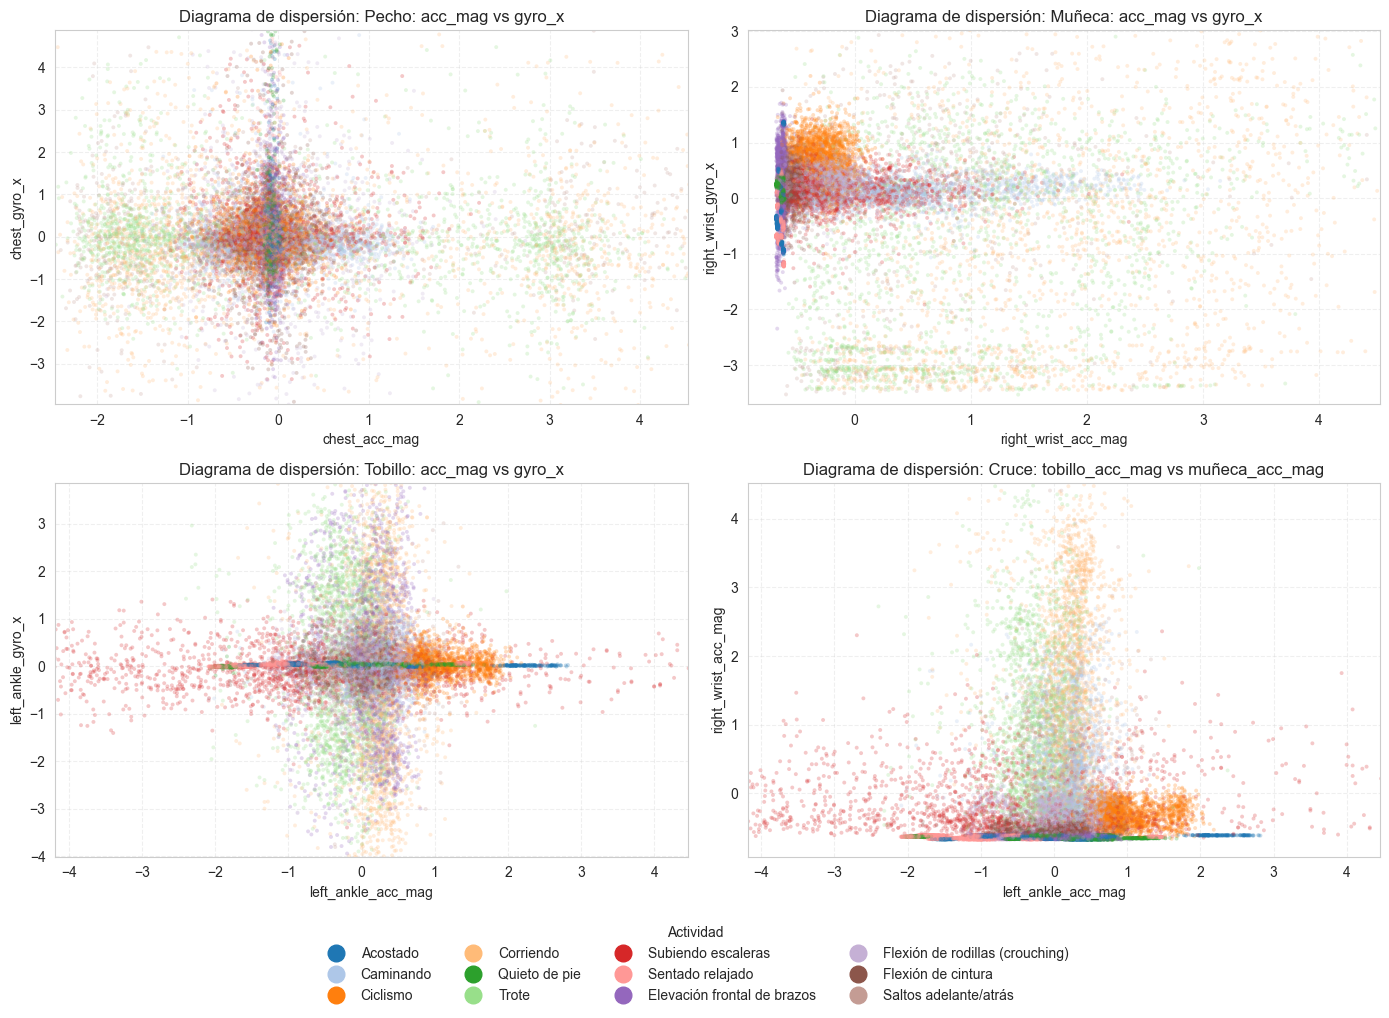

In [38]:
from matplotlib.lines import Line2D

df_sc = plot_df_z.copy()
df_sc = df_sc[df_sc['activity'] != 0]
if pd.api.types.is_categorical_dtype(df_sc['activity_name']):
    df_sc['activity_name'] = df_sc['activity_name'].cat.remove_unused_categories()

# orden y paleta por actividad
act_order = (df_sc.groupby('activity_name', as_index=False)
                 .size()
                 .sort_values('size', ascending=False)['activity_name']
                 .tolist())
palette = sns.color_palette('tab20', n_colors=len(act_order))
palette_map = dict(zip(act_order, palette))

# muestreo
SCATTER_SAMPLE = 20_000  # poner None para todo
if SCATTER_SAMPLE and len(df_sc) > SCATTER_SAMPLE:
    df_sc = df_sc.sample(SCATTER_SAMPLE, random_state=42)

pairs = [
    ('chest_acc_mag',       'chest_gyro_x',        'Pecho: acc_mag vs gyro_x'),
    ('right_wrist_acc_mag', 'right_wrist_gyro_x',  'Muñeca: acc_mag vs gyro_x'),
    ('left_ankle_acc_mag',  'left_ankle_gyro_x',   'Tobillo: acc_mag vs gyro_x'),
    ('left_ankle_acc_mag',  'right_wrist_acc_mag', 'Cruce: tobillo_acc_mag vs muñeca_acc_mag')
]

def robust_limits(x, y, q=0.005, pad=0.05):
    xlo, xhi = np.nanquantile(x, [q, 1-q])
    ylo, yhi = np.nanquantile(y, [q, 1-q])
    return (xlo - pad*(xhi-xlo), xhi + pad*(xhi-xlo)), (ylo - pad*(yhi-ylo), yhi + pad*(yhi-ylo))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (xcol, ycol, title) in zip(axes, pairs):
    (xlo, xhi), (ylo, yhi) = robust_limits(df_sc[xcol], df_sc[ycol])
    sns.scatterplot(
        data=df_sc, x=xcol, y=ycol,
        hue='activity_name', hue_order=act_order,
        palette=palette_map, legend=False,  # <- sin leyenda por-ax
        s=8, alpha=0.25, linewidth=0, ax=ax
    )
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_title(f'Diagrama de dispersión: {title}')
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.grid(True, linestyle='--', alpha=0.3)

# ---- Leyenda consolidada abajo ----

handles = [Line2D([0], [0], marker='o', linestyle='', markersize=6, color=palette_map[a])
           for a in act_order]
fig.legend(handles, act_order, title='Actividad',
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02), frameon=False)

fig.tight_layout(rect=[0, 0.08, 1, 1])  # deja espacio para la leyenda
plt.show()


#### Interpretación de Densidades KDE
Pecho (acc_mag vs gyro_x): nube densa alrededor de (0,0) con dispersión vertical; el torso pasa mucho tiempo estable (baja acc_mag) y los giros aparecen en ráfagas cortas. Útil para distinguir posturas vs transiciones, menos para graduar intensidad de locomoción.

Muñeca (acc_mag vs gyro_x): patrón en “abanico”: a mayor acc_mag aumenta la variabilidad de giro. Buen contraste entre estáticas (cerca del origen) y dinámicas (correr/saltos en la zona alta). Elevación de brazos muestra gyro alto con acc moderada, señal de gestos rotacionales del brazo.

Tobillo (acc_mag vs gyro_x): la mejor señal de locomoción. Se aprecia un eje horizontal denso cerca de gyro≈0 (fase de apoyo) y mayor dispersión de giros para caminar/trote/correr, junto con acc_mag más alta (impactos de zancada). Ciclismo queda intermedio: rotaciones presentes pero acc_mag menos extrema que correr/saltos.

Cruce tobillo_acc_mag vs muñeca_acc_mag: clara correlación positiva en actividades locomotoras (ambos altos). Se diferencian bien tres zonas:

Origen (ambos bajos): posturas estáticas.

Muñeca alta / tobillo bajo: actividad de miembro superior (elevación de brazos).

Tobillo alto / muñeca moderada–alta: caminar–correr–saltos.
Esto sugiere features como razones o umbrales (p. ej., muñeca/tobillo) para separar upper-limb only de locomoción.

En conjunto, los diagramas refuerzan el análisis previo: tobillo + muñeca ofrecen la mayor separabilidad por actividad; el pecho discrimina posturas y transiciones.

## Tarea 2: Visualización de series temporales


### Preparación (segmentos, tiempo y helpers)

In [ ]:
FS = 50            # Hz (MHEALTH)
WIN_SECONDS = 15   # duración de cada ventana para graficar
SMOOTH_SEC = 0.20  # suavizado visual (solo para plots)
_win = max(1, int(SMOOTH_SEC * FS))

def build_segments(df, fs=FS):
    """
    Crea IDs de segmento continuo por (subject, activity) y un tiempo relativo t_seg (s).
    No reordena el DataFrame: respeta el orden actual de df.
    """
    out = df.copy()
    is_new = (out['subject'] != out['subject'].shift()) | (out['activity'] != out['activity'].shift())
    out['seg_id']  = is_new.cumsum()
    out['t_seg']   = out.groupby('seg_id').cumcount() / fs
    out['seg_len'] = out.groupby('seg_id')['seg_id'].transform('size') / fs
    return out

def pick_segment(df, activity_name, seconds=WIN_SECONDS, subject=None):
    """Devuelve un segmento continuo (>= seconds) para la actividad/sujeto pedido."""
    _df = df[df['activity_name'] == activity_name]
    if subject is not None:
        _df = _df[_df['subject'] == subject]
    if _df.empty:
        raise ValueError(f"Sin datos para '{activity_name}'" + (f" en subject={subject}" if subject else ""))
    valid_ids = _df.loc[_df['seg_len'] >= seconds, 'seg_id'].unique().tolist()
    if not valid_ids:
        raise ValueError(f"No hay segmentos de ≥{seconds}s para '{activity_name}'"
                         + (f" en subject={subject}" if subject else ""))
    seg = _df[_df['seg_id'] == valid_ids[0]]
    return seg[seg['t_seg'] <= seconds].copy()

def smooth_series(x, win=_win):
    """Media móvil centrada para visual (no altera datos de fondo)."""
    if win <= 1:
        return x
    return pd.Series(x, copy=False).rolling(win, min_periods=1, center=True).mean().to_numpy()

# Construir segmentación una vez (y alinear en df_z)
df   = build_segments(df)
df_z = df_z.copy()
df_z[['seg_id','t_seg','seg_len']] = df[['seg_id','t_seg','seg_len']]


### Series temporales por actividad (un sujeto)

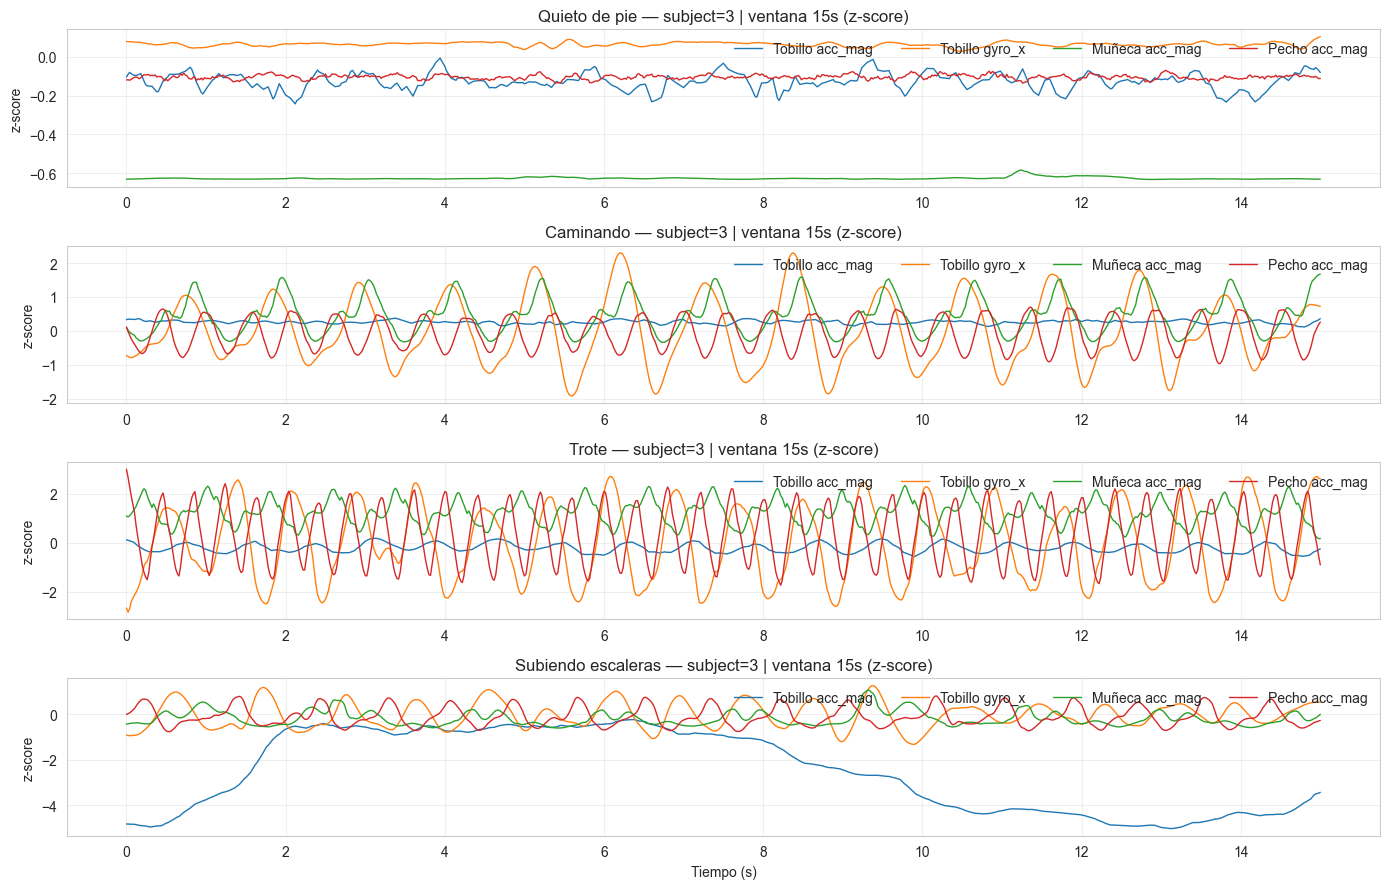

In [ ]:
# --- Series temporales: varias actividades de un mismo sujeto (z-score) ---
ACTS = ['Quieto de pie', 'Caminando', 'Trote', 'Subiendo escaleras']
SENSORS = [
    ('left_ankle_acc_mag', 'Tobillo acc_mag'),
    ('left_ankle_gyro_x',  'Tobillo gyro_x'),
    ('right_wrist_acc_mag','Muñeca acc_mag'),
    ('chest_acc_mag',      'Pecho acc_mag'),
]
SUBJECT = 3  # si None, toma el primer sujeto con segmentos válidos

fig, axes = plt.subplots(len(ACTS), 1, figsize=(14, 9), sharex=False)
axes = np.atleast_1d(axes)

for ax, act in zip(axes, ACTS):
    seg = pick_segment(df_z, act, seconds=WIN_SECONDS, subject=SUBJECT)
    subj = int(seg['subject'].iloc[0])
    t = seg['t_seg'].to_numpy()
    for col, label in SENSORS:
        ax.plot(t, smooth_series(seg[col].to_numpy()), linewidth=1, label=label)
    ax.set_title(f"{act} — subject={subj} | ventana {WIN_SECONDS}s (z-score)")
    ax.set_ylabel('z-score')
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=4, frameon=False, loc='upper right')

axes[-1].set_xlabel('Tiempo (s)')
fig.tight_layout()
plt.show()


En general, quieto de pie muestra trazas casi planas (baja varianza) en todos los sensores. En caminando aparece una oscilación periódica clara en los sensores. En trote suben frecuencia y amplitud simultáneamente en las tres ubicaciones, diferenciándose de caminar. En subiendo escaleras hay periodicidad moderada, destacando una deriva en left_ankle_acc_mag (cambio de nivel/orientación por la subida).

### Comparación

#### Comparación entre sujetos (misma actividad)

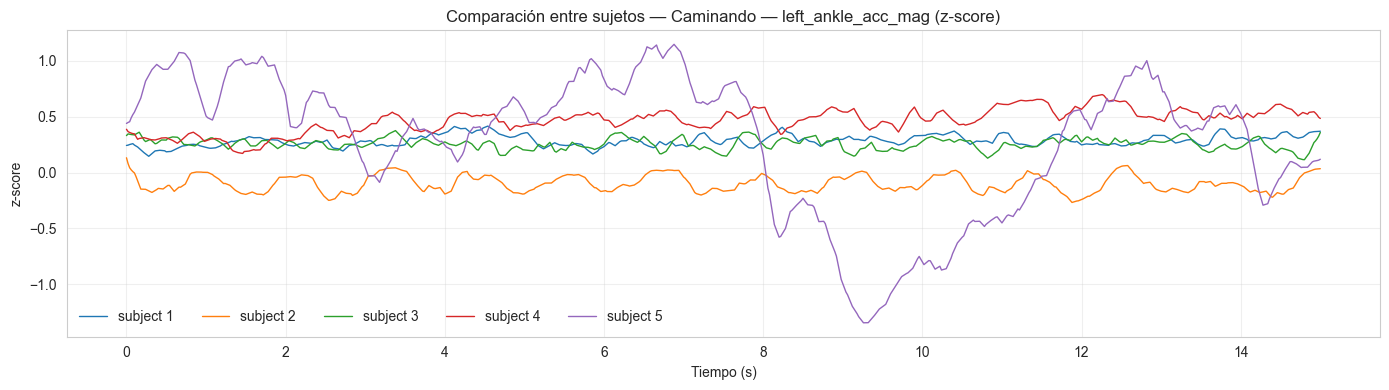

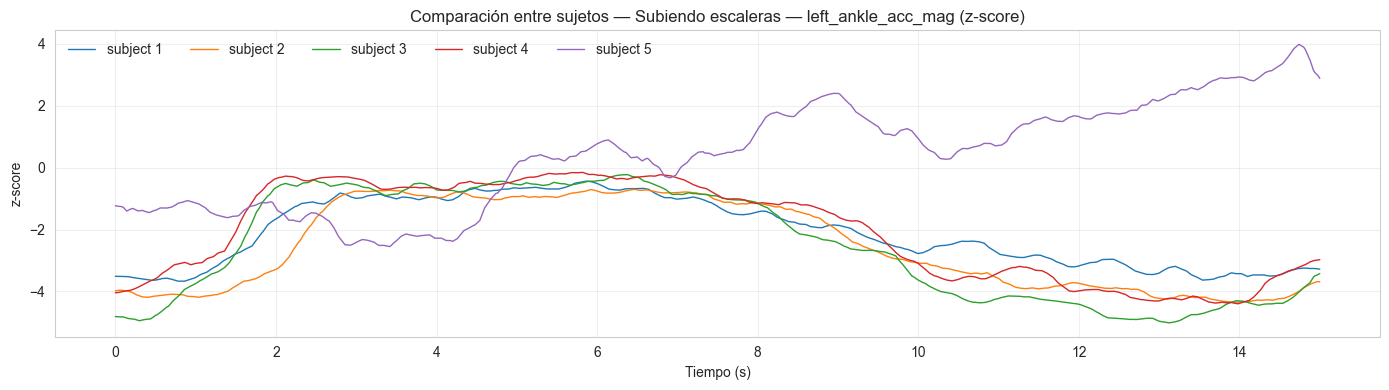

In [ ]:
# --- Comparación entre sujetos: misma actividad, misma señal ---
ACT     = 'Caminando'           # actividad 1 a comparar
SENSOR  = 'left_ankle_acc_mag'  # señal a comparar
N_SUBJS = 5                     # cuántos sujetos superponer

subjects = (df_z[df_z['activity_name'] == ACT]['subject']
            .drop_duplicates().sort_values().head(N_SUBJS).tolist())

plt.figure(figsize=(14, 4))
for s in subjects:
    seg = pick_segment(df_z, ACT, seconds=WIN_SECONDS, subject=s)
    t = seg['t_seg'].to_numpy()
    plt.plot(t, smooth_series(seg[SENSOR].to_numpy()), linewidth=1, label=f"subject {int(s)}")

plt.title(f"Comparación entre sujetos — {ACT} — {SENSOR} (z-score)")
plt.xlabel('Tiempo (s)')
plt.ylabel('z-score')
plt.grid(True, alpha=0.3)
plt.legend(ncol=min(5, len(subjects)), frameon=False)
plt.tight_layout()
plt.show()

ACT     = 'Subiendo escaleras'            # actividad 2 a comparar

plt.figure(figsize=(14, 4))
for s in subjects:
    seg = pick_segment(df_z, ACT, seconds=WIN_SECONDS, subject=s)
    t = seg['t_seg'].to_numpy()
    plt.plot(t, smooth_series(seg[SENSOR].to_numpy()), linewidth=1, label=f"subject {int(s)}")

plt.title(f"Comparación entre sujetos — {ACT} — {SENSOR} (z-score)")
plt.xlabel('Tiempo (s)')
plt.ylabel('z-score')
plt.grid(True, alpha=0.3)
plt.legend(ncol=min(5, len(subjects)), frameon=False)
plt.tight_layout()
plt.show()


Caminando:
Se ve una señal cuasi-periódica con amplitud distinta por sujeto: subject 5 es el más variable (picos y un evento pronunciado ~8–11 s que podría ser giro/transición o artefacto), subject 4 moderado–alto y 1–3 más contenidos. La cadencia visual es parecida entre sujetos (patrón estable), pero hay desplazamientos de nivel suaves (ligeras derivas) que reflejan diferencias de orientación/ajuste del sensor.

Subiendo escaleras:
Predomina una deriva marcada (tendencia) distinta por sujeto: 1–4 muestran pendiente negativa sostenida mientras 5 es positiva. Las oscilaciones de paso están, pero quedan superpuestas a la tendencia, lo que es consistente con cambios de inclinación del pie y proyección de la gravedad al subir. La variabilidad inter-sujeto es mayor que en caminar.

#### Comparación entre actividades (mismo sujeto)

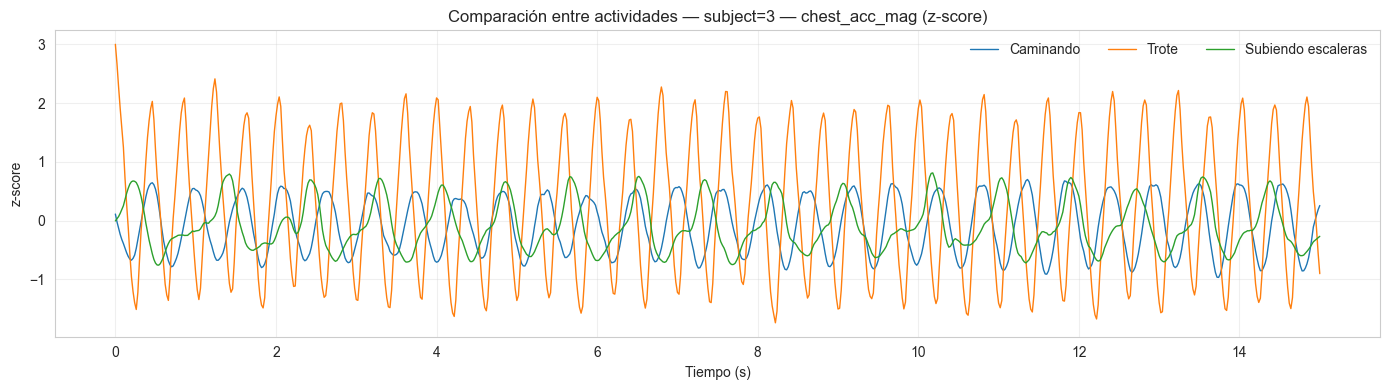

In [ ]:
# --- Comparación entre actividades: mismo sujeto, misma señal ---
SENSOR  = 'chest_acc_mag'
ACTS_cmp = ['Caminando', 'Trote', 'Subiendo escaleras'] 

plt.figure(figsize=(14, 4))
for act in ACTS_cmp:
    seg = pick_segment(df_z, act, seconds=WIN_SECONDS, subject=SUBJECT)
    t = seg['t_seg'].to_numpy()
    plt.plot(t, smooth_series(seg[SENSOR].to_numpy()), linewidth=1, label=act)

plt.title(f"Comparación entre actividades — subject={SUBJECT} — {SENSOR} (z-score)")
plt.xlabel('Tiempo (s)')
plt.ylabel('z-score')
plt.grid(True, alpha=0.3)
plt.legend(ncol=len(ACTS_cmp), frameon=False)
plt.tight_layout()
plt.show()


Trote: es la señal más energética: oscilación casi sinusoidal, amplitud mayor (picos ~±2–3 z) y frecuencia alta y estable (cadencia rápida).

Caminando: tiene menor amplitud (≈±0.5–0.8 z) y frecuencia más baja, con ciclos bien marcados pero suaves.

Subiendo escaleras: queda intermedio en amplitud y con forma menos regular: picos algo asimétricos y leve modulación/deriva, coherente con la inclinación y cambios de postura del tronco al subir.

## Tarea 3: Visualización de correlaciones

In [ ]:
FEATURES_BASE = [
    'chest_acc_mag','right_wrist_acc_mag','left_ankle_acc_mag',
    'chest_gyro_x','right_wrist_gyro_x','left_ankle_gyro_x'
]

def corr_heatmap(df, cols, method='pearson', title='', vmax=1.0):
    """
    Dibuja heatmap de correlación con máscara superior.
    method: 'pearson' (lineal) o 'spearman' (monótona/robusta a outliers).
    """
    X = df[cols].dropna().astype('float32')
    C = X.corr(method=method)
    mask = np.triu(np.ones_like(C, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(C, mask=mask, annot=True, fmt=".2f",
                cmap='coolwarm', vmin=-vmax, vmax=vmax, center=0,
                square=True, cbar_kws={'shrink': .8})
    plt.title(title or f'Matriz de correlación ({method})')
    plt.tight_layout()
    plt.show()
    return C


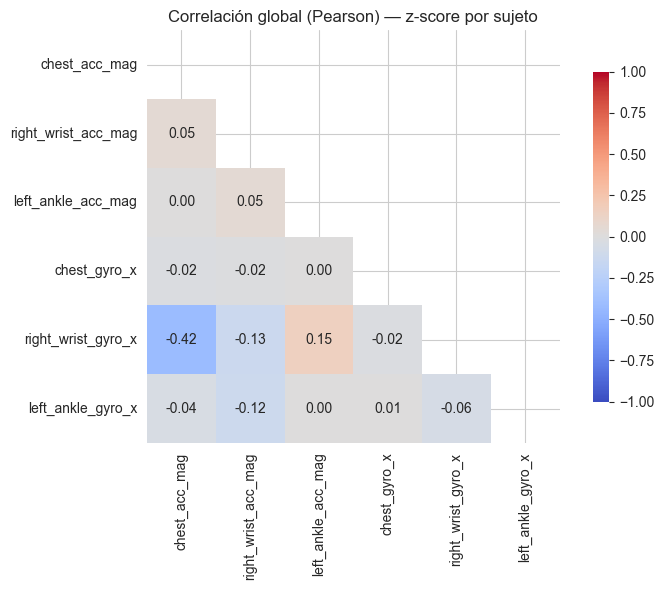

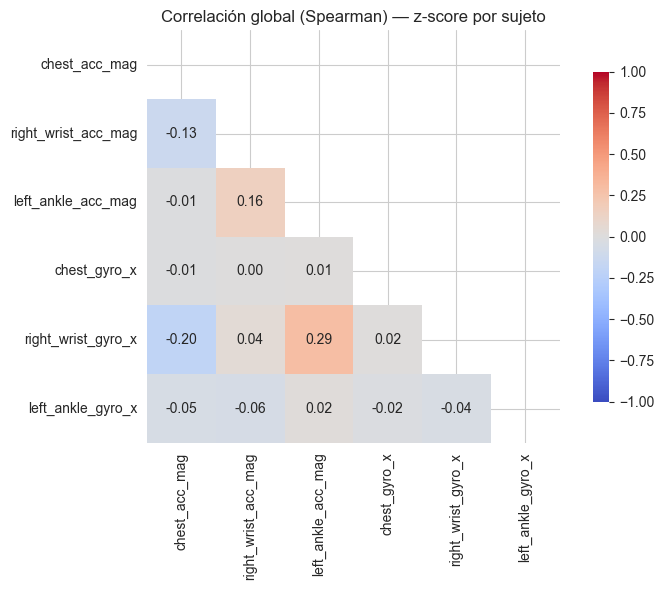

In [ ]:
# Pearson (lineal)
C_pearson = corr_heatmap(
    df=df_z, cols=FEATURES_BASE, method='pearson',
    title='Correlación global (Pearson) — z-score por sujeto'
)

# Spearman (monótona, más robusta a no linealidades/outliers)
C_spearman = corr_heatmap(
    df=df_z, cols=FEATURES_BASE, method='spearman',
    title='Correlación global (Spearman) — z-score por sujeto'
)


chest_acc_mag ↔ right_wrist_gyro_x: correlación negativa moderada (≈ −0.42 Pearson; −0.20 Spearman). Interpretable como “cuando el brazo rota mucho (gestos de MI superior), el tronco acelera poco”, y al mezclar con locomoción aparece la tendencia inversa. Que Spearman sea menos negativo sugiere no linealidad/outliers.

left_ankle_acc_mag ↔ right_wrist_gyro_x: positiva débil-moderada (≈ 0.15 Pearson; 0.29 Spearman): con mayor aceleración en tobillo (marcha/trote) suele aumentar la rotación de muñeca por el balanceo.

right_wrist_acc_mag ↔ left_ankle_acc_mag: positiva muy débil (0.05 P; 0.16 S), coherente con movimiento coordinado en locomoción.

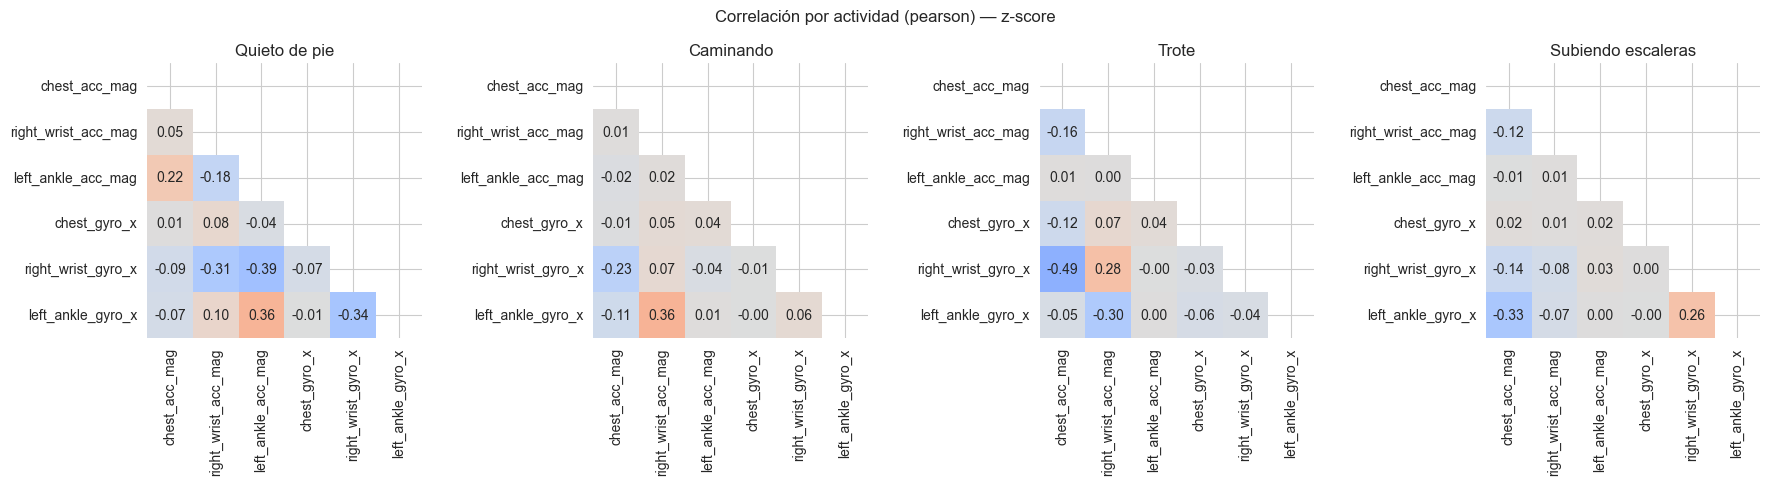

In [ ]:
ACTS = ['Quieto de pie','Caminando','Trote','Subiendo escaleras']  # ajusta a gusto
method = 'pearson'  # o 'spearman'

n = len(ACTS)
fig, axes = plt.subplots(1, n, figsize=(4.5*n, 4.5), squeeze=False)
axes = axes.ravel()

for ax, act in zip(axes, ACTS):
    X = df_z[df_z['activity_name'] == act][FEATURES_BASE].dropna().astype('float32')
    C = X.corr(method=method)
    mask = np.triu(np.ones_like(C, dtype=bool))
    sns.heatmap(C, mask=mask, annot=True, fmt=".2f",
                cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, cbar=False, ax=ax)
    ax.set_title(act)

plt.suptitle(f'Correlación por actividad ({method}) — z-score', y=1.02)
plt.tight_layout()
plt.show()


Quieto de pie: correlaciones en general bajas, salvo:

left_ankle_acc_mag ↔ left_ankle_gyro_x positiva (~0.36): micromovimientos del pie.

right_wrist_gyro_x negativo con right_wrist_acc_mag y left_ankle_acc_mag (~−0.31/−0.39): gestos de brazo sin acompañamiento del resto del cuerpo.

Caminando: aparecen acoples de locomoción:

right_wrist_acc_mag ↔ left_ankle_gyro_x positivo (~0.36): balanceo de brazos sincronizado con la rotación del tobillo.

right_wrist_gyro_x ↔ chest_acc_mag negativo (≈−0.23): cuando el brazo rota más, el tronco acelera menos (fase/antifase leve).

Trote: se refuerzan patrones del miembro superior:

right_wrist_gyro_x ↔ chest_acc_mag negativo fuerte (≈−0.49) y right_wrist_gyro_x ↔ right_wrist_acc_mag positivo (≈0.28): la muñeca concentra la energía y el tronco mantiene aceleración más estable.

right_wrist_acc_mag ↔ left_ankle_gyro_x negativo (~−0.30): desfasaje brazo-pierna más marcado que al caminar.

Subiendo escaleras: correlaciones moderadas y asimétricas:

left_ankle_gyro_x ↔ chest_acc_mag negativo (~−0.33) y positivo con right_wrist_gyro_x (≈0.26): la inclinación del cuerpo y el patrón de zancada alteran la coordinación típica de marcha.

In [ ]:
from itertools import combinations
from scipy.stats import pearsonr, spearmanr

def significant_pairs(df, cols, method='pearson', alpha=0.05, fdr=True):
    """
    Calcula r y p para todos los pares; ajusta FDR (Benjamini-Hochberg) si fdr=True.
    Devuelve un DataFrame ordenado por |r|.
    """
    rows = []
    X = df[cols].dropna().astype('float32')
    for a, b in combinations(cols, 2):
        if method == 'spearman':
            r, p = spearmanr(X[a], X[b])
        else:
            r, p = pearsonr(X[a], X[b])
        rows.append((a, b, r, p))
    out = pd.DataFrame(rows, columns=['var1','var2','r','p'])

    if fdr:
        # Benjamini–Hochberg
        m = len(out)
        out = out.sort_values('p').reset_index(drop=True)
        out['rank'] = np.arange(1, m+1)
        out['p_fdr'] = out['p'] * m / out['rank']
        out['p_fdr'] = out['p_fdr'].clip(upper=1.0)
        out['sig'] = out['p_fdr'] < alpha
        out = out.sort_values('r', key=np.abs, ascending=False).drop(columns='rank')
    else:
        out['sig'] = out['p'] < alpha
        out = out.sort_values('r', key=np.abs, ascending=False)

    return out

sig_global = significant_pairs(df_z, FEATURES_BASE, method='pearson', alpha=0.05, fdr=True)
sig_global.head(20)


,var1,var2,r,p,p_fdr,sig
0,chest_acc_mag,right_wrist_gyro_x,-0.421817,0.000000e+00,0.000000e+00,True
2,left_ankle_acc_mag,right_wrist_gyro_x,0.151030,0.000000e+00,0.000000e+00,True
1,right_wrist_acc_mag,right_wrist_gyro_x,-0.132365,0.000000e+00,0.000000e+00,True
3,right_wrist_acc_mag,left_ankle_gyro_x,-0.123523,0.000000e+00,0.000000e+00,True
4,right_wrist_gyro_x,left_ankle_gyro_x,-0.060144,1.967140e-272,5.901419e-272,True
5,chest_acc_mag,right_wrist_acc_mag,0.053867,7.078884e-219,1.769721e-218,True
6,right_wrist_acc_mag,left_ankle_acc_mag,0.050149,5.947569e-190,1.274479e-189,True
7,chest_acc_mag,left_ankle_gyro_x,-0.040267,3.949639e-123,7.405574e-123,True
8,chest_gyro_x,right_wrist_gyro_x,-0.022257,7.194164e-39,1.199027e-38,True
9,chest_acc_mag,chest_gyro_x,-0.021805,2.243241e-37,3.364862e-37,True


chest_acc_mag ↔ right_wrist_gyro_x: r = −0.42 → moderado negativo (≈18% de varianza explicada, r²≈0.18). Coherente con lo que vimos: cuando el brazo rota mucho (gesto MI sup.), el tronco no incrementa tanto su aceleración global, y viceversa; además, al mezclar actividades aparece antifase.

left_ankle_acc_mag ↔ right_wrist_gyro_x: r = 0.15 → débil positivo (r²≈2.3%): locomoción aumenta rotación de muñeca por balanceo.

## Tarea 4: Visualización por clases

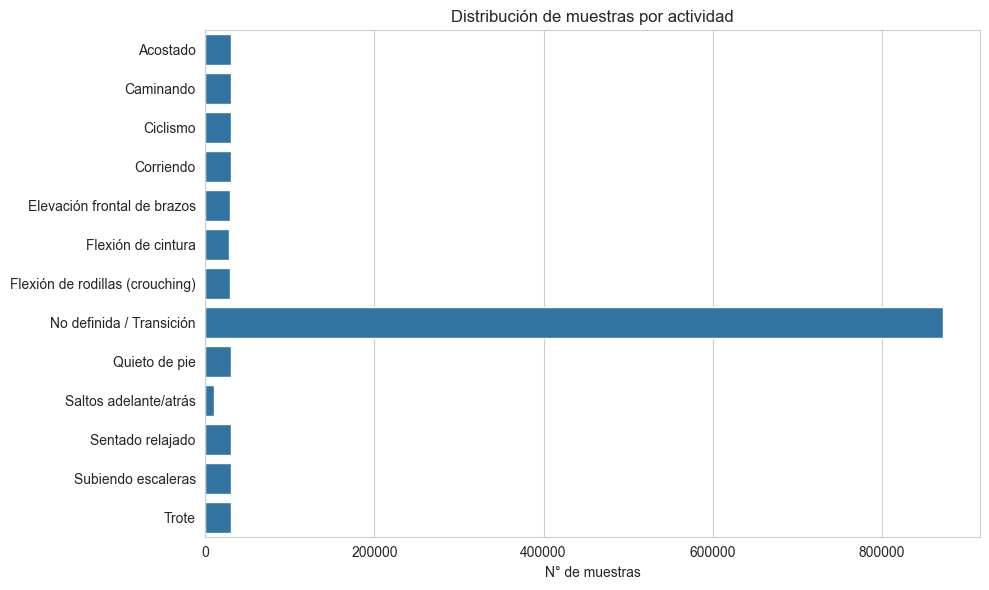

In [ ]:
df_cls = mhealth_df.copy()

# Conteo robusto por clase (sin warnings de observed)
counts = (df_cls['activity_name']
          .value_counts(dropna=False)              # cuenta por clase
          .sort_values(ascending=True)            # orden para barra horizontal
          .rename_axis('activity_name')
          .reset_index(name='size'))

plt.figure(figsize=(10, 6))
sns.barplot(data=counts, y='activity_name', x='size')
plt.title('Distribución de muestras por actividad')
plt.xlabel('N° de muestras')
plt.ylabel('')
plt.tight_layout()
plt.show()


Aqui podemos ver la gran cantidad de datos que tenemos con actividad 0 (transición) y como afecta a la distribución de las demás clases. Por eso es importante eliminar estas filas para tener una mejor visualización. Ademas podemos observar que la actividad "Saltos adelante/atrás" tiene pocos datos en comparación con las demás actividades, lo que podría afectar el rendimiento de un modelo de clasificación si no se maneja adecuadamente el desbalanceo de clases.

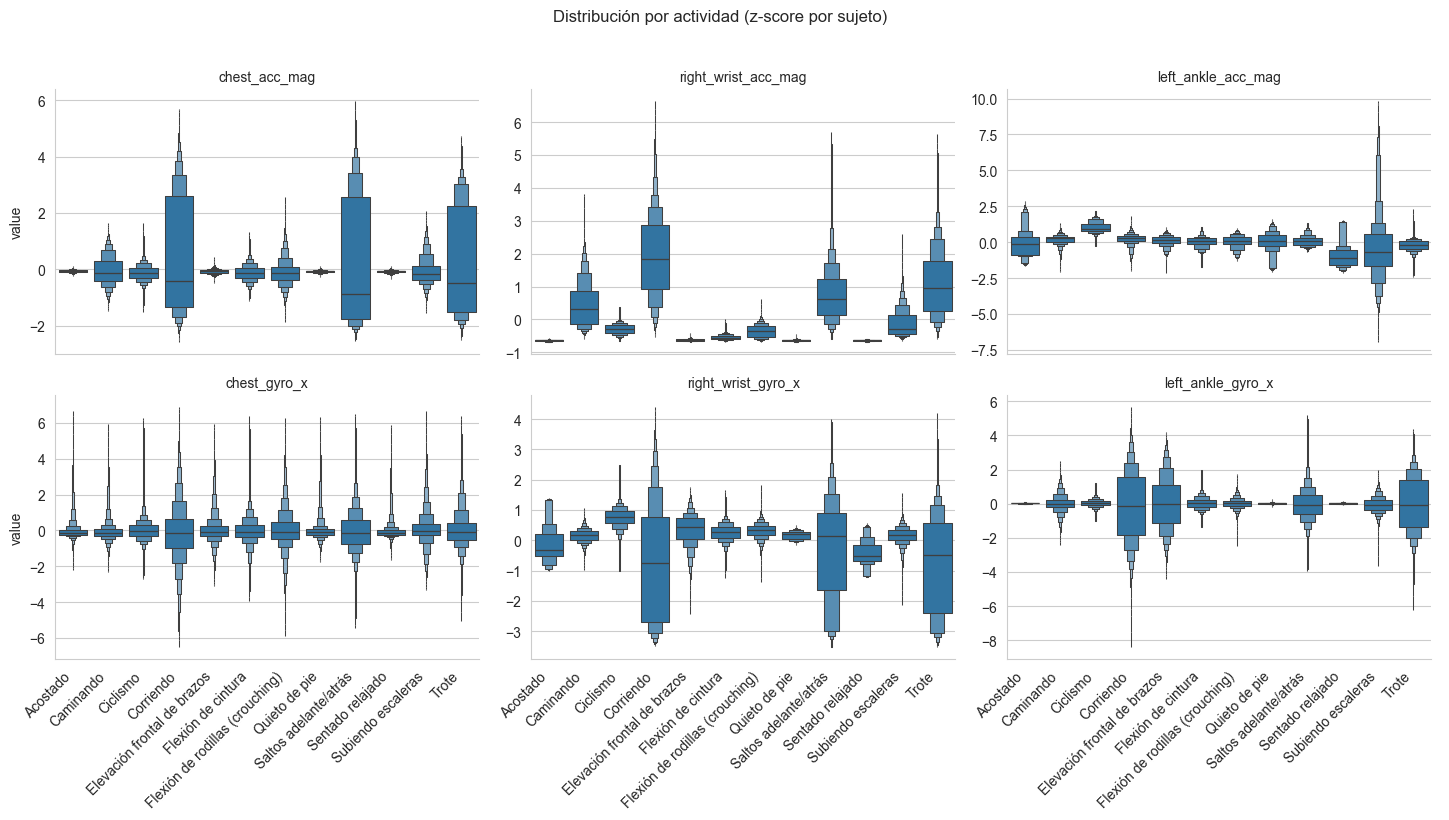

In [ ]:
from pandas.api.types import CategoricalDtype
FEATS = [
    'chest_acc_mag','right_wrist_acc_mag','left_ankle_acc_mag',
    'chest_gyro_x','right_wrist_gyro_x','left_ankle_gyro_x'
]

df_long = df_z[['activity_name'] + FEATS].melt(
    id_vars='activity_name', var_name='feature', value_name='value'
)
if isinstance(df_long['activity_name'].dtype, CategoricalDtype):
    df_long['activity_name'] = df_long['activity_name'].cat.remove_unused_categories()

g = sns.catplot(
    data=df_long, x='activity_name', y='value', col='feature',
    kind='boxen', col_wrap=3, sharey=False, height=4, aspect=1.2,
    showfliers=False
)
for ax in g.axes.flat:
    ax.set_xlabel('')
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')
g.set_titles('{col_name}')
g.fig.suptitle('Distribución por actividad (z-score por sujeto)', y=1.02)
plt.tight_layout()
plt.show()


los boxenplots por actividad muestran un patrón coherente y bien separable. En posturas estáticas (acostado, sentado, quieto) las distribuciones son estrechas y centradas cerca de 0 en todos los sensores (baja energía). En locomoción (caminar → trote/correr → saltos) crecen claramente la mediana y el rango en left_ankle_acc_mag y left_ankle_gyro_x (tobillo), seguidos por la muñeca (right_wrist_acc_mag/gyro_x), mientras que el pecho aumenta menos y sirve más para distinguir postura vs movimiento. Elevación de brazos resalta la muñeca (aceleración/giros altos) con tobillo y pecho más contenidos, y ciclismo queda intermedio (giros de tobillo moderados y muñeca menos energética que trote/correr). Se observan sesgos de signo en algunas actividades (p. ej., medianas negativas en left_ankle_acc_mag al correr), consistentes con cambios de orientación/gravedad aún presentes pese al z-score.

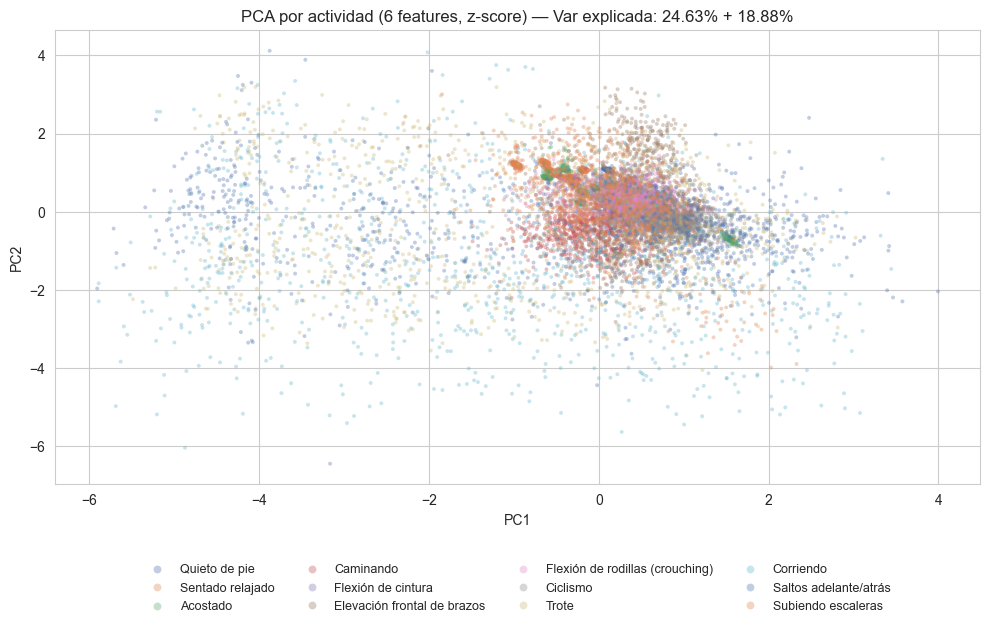

Varianza acumulada por componentes:
  Componente 1: 24.6349% (acum: 24.6349%)
  Componente 2: 18.8806% (acum: 43.5155%)
  Componente 3: 16.6648% (acum: 60.1802%)
  Componente 4: 16.5312% (acum: 76.7114%)
  Componente 5: 14.6011% (acum: 91.3125%)
  Componente 6: 8.6875% (acum: 100.0000%)


In [37]:

from sklearn.decomposition import PCA


# Dataset completo (z-score por sujeto), sin NaNs, para AJUSTAR el PCA
Xy_full = df_z[['activity_name'] + FEATS].dropna().copy()
X_full  = Xy_full[FEATS].astype('float32').to_numpy()
acts_full = Xy_full['activity_name'].to_numpy()

# ----- 2) Ajustar PCA con todo el dataset -----
pca = PCA(n_components=len(FEATS), svd_solver='auto', random_state=42)
pca.fit(X_full)

# ----- 3) Muestra ESTRATIFICADA para visualizar -----
MAX_PER_CLASS = 1000  # ajusta según máquina (p.ej., 3000-10000)
idx_parts = []
rng = np.random.default_rng(42)
for act, grp in Xy_full.groupby('activity_name', sort=False, observed=False):
    take = min(MAX_PER_CLASS, len(grp))
    idx_parts.append(grp.sample(take, random_state=42).index.to_numpy())
sample_idx = np.concatenate(idx_parts)

Z_sample = pca.transform(X_full[np.searchsorted(Xy_full.index, sample_idx)])
acts_sample = acts_full[np.searchsorted(Xy_full.index, sample_idx)]

# ----- 4) Scatter PC1 vs PC2 -----
pc_df = pd.DataFrame({
    'PC1': Z_sample[:, 0],
    'PC2': Z_sample[:, 1],
    'activity_name': acts_sample
})
plt.figure(figsize=(10, 7))

pal = sns.color_palette("deep", n_colors=len(pc_df['activity_name'].unique()))
palette_map = dict(zip(pc_df['activity_name'].unique(), pal))

sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='activity_name',
                s=8, alpha=0.35, linewidth=0, palette=palette_map)
plt.title(f'PCA por actividad (6 features, z-score) — Var explicada: '
          f'{pca.explained_variance_ratio_[0]:.2%} + {pca.explained_variance_ratio_[1]:.2%}')
# Aumentar tamaño de los puntos en la leyenda
plt.rcParams['legend.markerscale'] = 2.0
ax = plt.gca()
h, lbs = ax.get_legend_handles_labels()
leg = ax.get_legend()
if leg:
    leg.remove()
ax.legend(h, lbs,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15),
          ncol=4,
          frameon=False,
          fontsize= 9)
# Reservar espacio inferior modificando esta única llamada a tight_layout
_orig_tl = plt.tight_layout
def _patched_tl(*args, **kwargs):
    kwargs.setdefault('rect', [0, 0.07, 1, 1])  # deja margen abajo
    out = _orig_tl(*args, **kwargs)
    plt.tight_layout = _orig_tl  # restaurar
    return out
plt.tight_layout = _patched_tl
plt.tight_layout()
plt.show()

# ----- 5) Resumen de varianza explicada -----
print("Varianza acumulada por componentes:")
cum = 0.0
for i, var in enumerate(pca.explained_variance_ratio_):
    cum += var
    print(f"  Componente {i+1}: {var:.4%} (acum: {cum:.4%})")


Se ve una posible separación con **PC1+PC2 ≈ 43.5%** de varianza: **PC1** parece ordenar por *intensidad/energía* (posturas estáticas cerca del origen y más compactas; **caminar → trote/correr/saltos** hacia valores más extremos), mientras **PC2** capturaría diferencias más **rotacionales** (p. ej., **elevación de brazos** se desplaza en PC2 con energía moderada). **Subiendo escaleras** queda intermedia y más dispersa (cambios de inclinación). Hay solapamiento entre **caminar/trote/correr** —esperable con PCs de señales instantáneas—, pero la separación entre **estáticas vs locomoción** es apreciable. Pero como podemos ver con la varianza acumulada, haría falta más PCs para capturar toda la complejidad y mejorar la discriminación entre clases.